In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [6]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    color = 'r'
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_XCRD
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [7]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_XCRD
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [8]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [9]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [10]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [11]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [12]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =0

nband = 180

ng =10

ng_refs = (/ 2 , 2 , 6 /) 

nref =3

nv = 200

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 10 , 500 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =300

vstar = 360

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66/

data wgt
     &     /0.4 , 0.4 , 0.4 , 0.4,
     &     0.4 , 0.4 , 0.4 , 0.4,
     &     0.4 , 0.7/

atmosphere_profiles/trp75.pro


In [13]:
fig.display_hrefanchor()

In [14]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [15]:
table_dgdgs.display_hrefanchor()

In [16]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [17]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [18]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

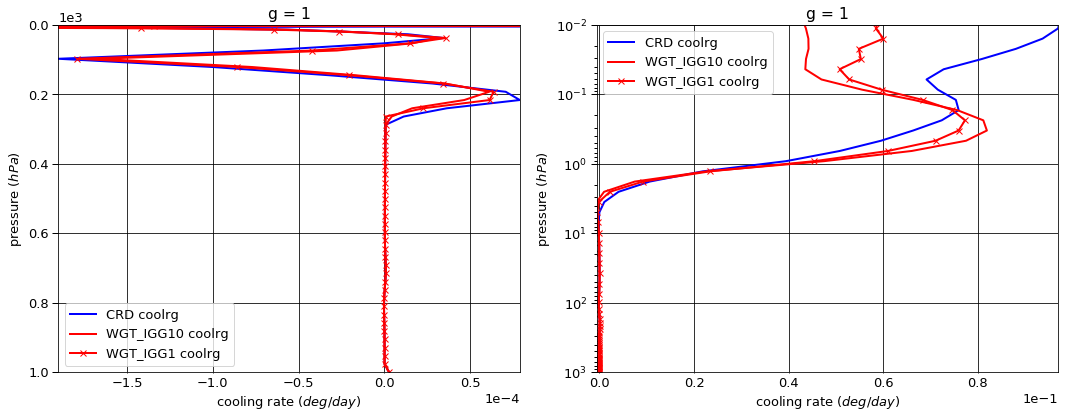

# Figure: cooling rate g-group 2

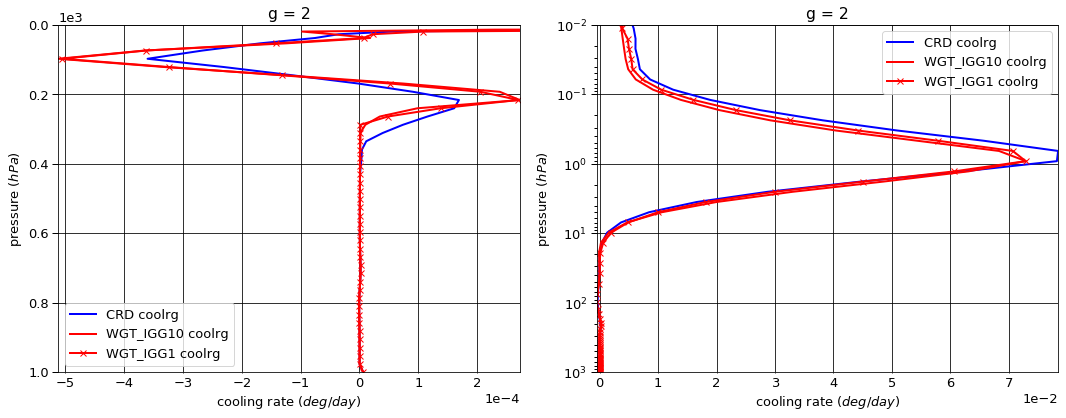

# Figure: cooling rate g-group 3

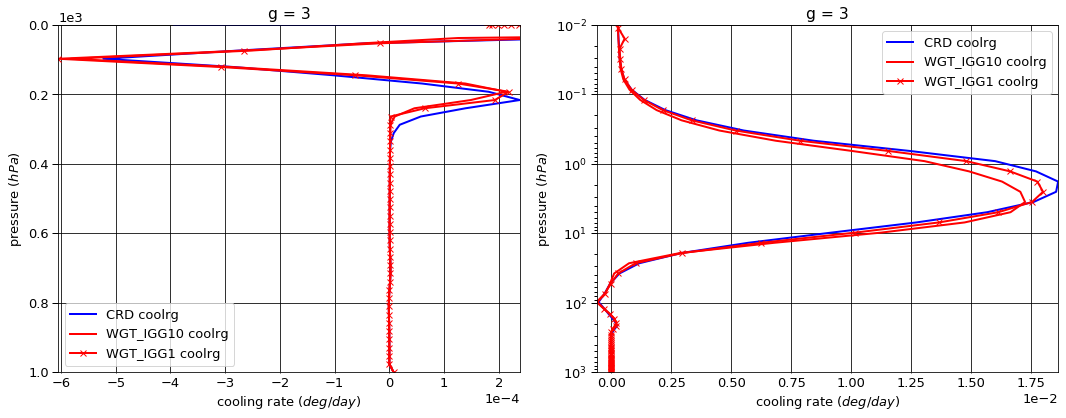

# Figure: cooling rate g-group 4

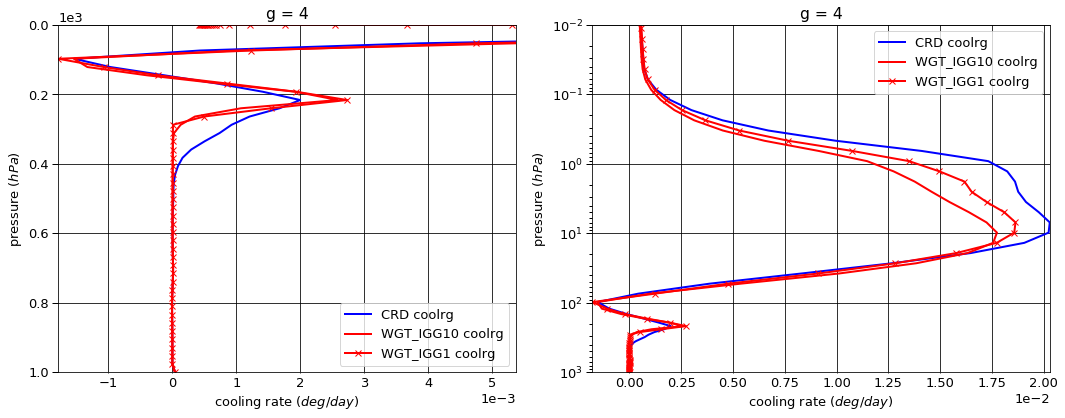

# Figure: cooling rate g-group 5

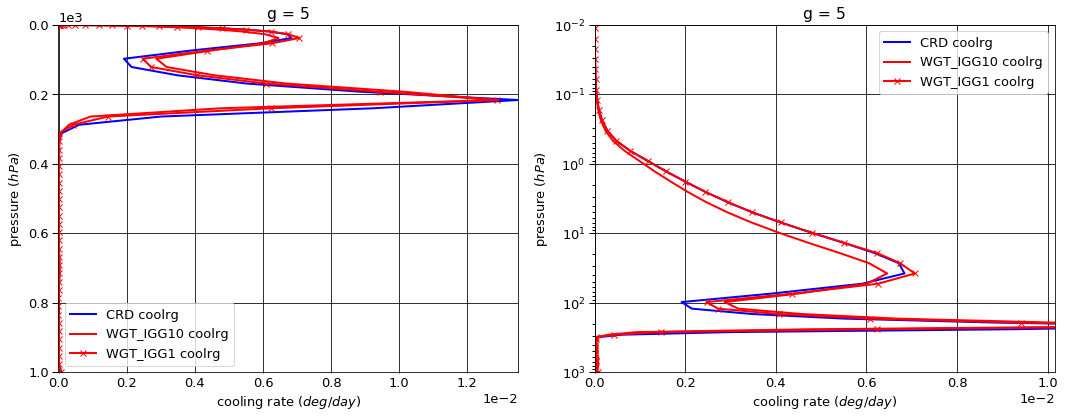

# Figure: cooling rate g-group 6

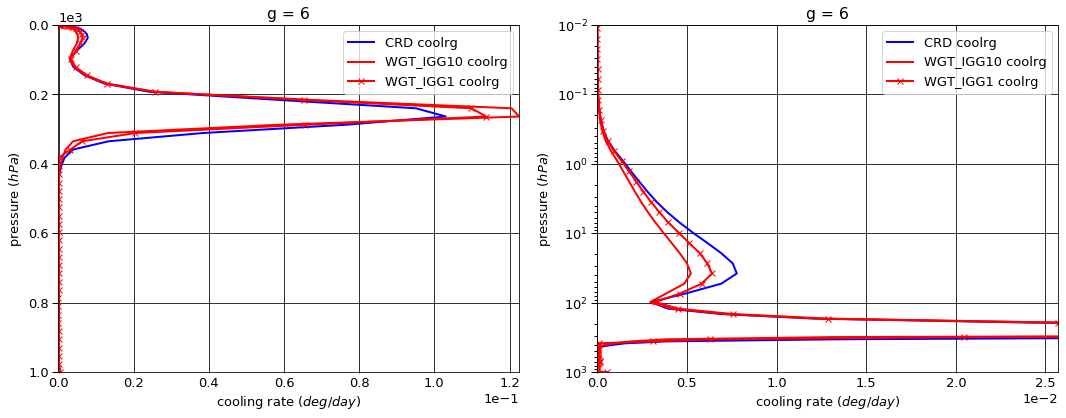

# Figure: cooling rate g-group 7

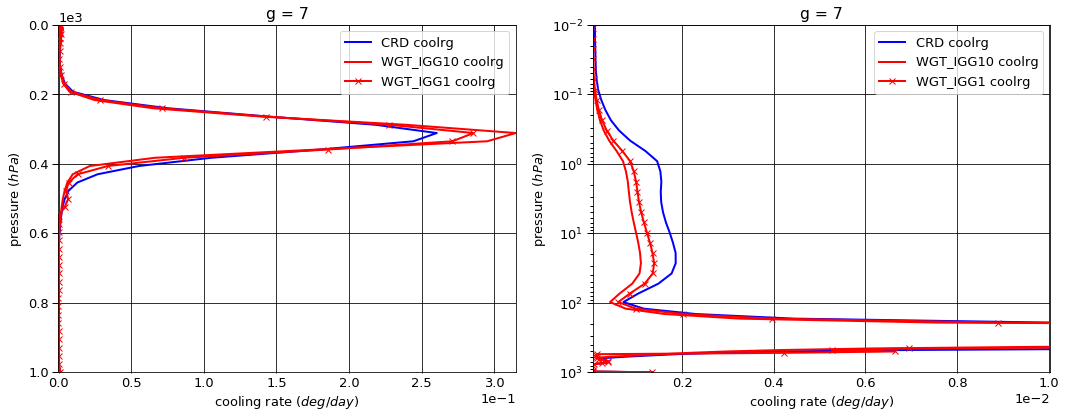

# Figure: cooling rate g-group 8

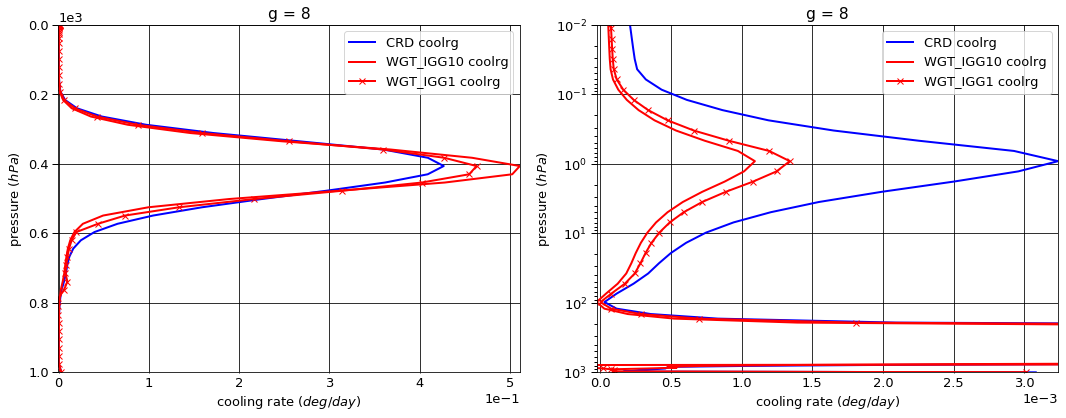

# Figure: cooling rate g-group 9

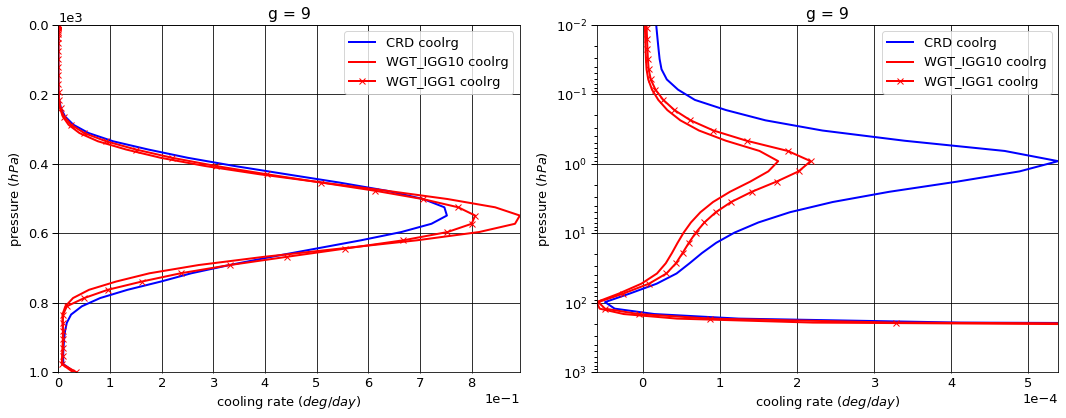

# Figure: cooling rate g-group 10

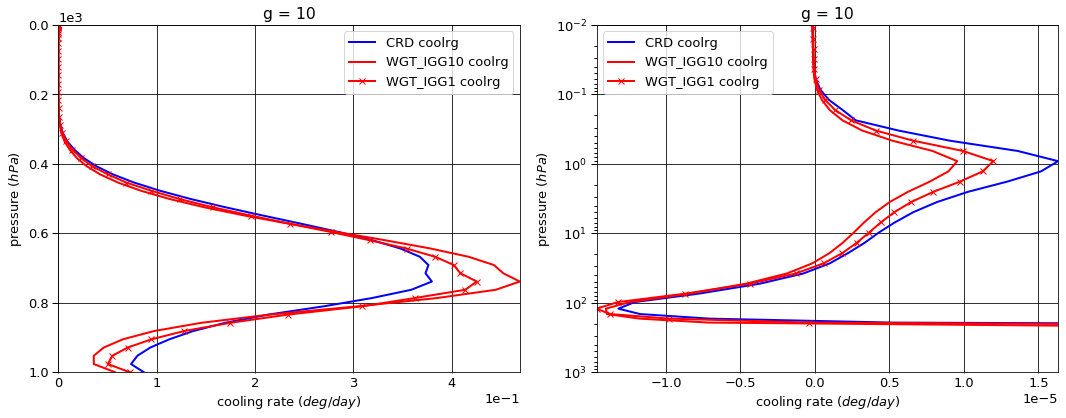

# Figure: cooling rate g-group total

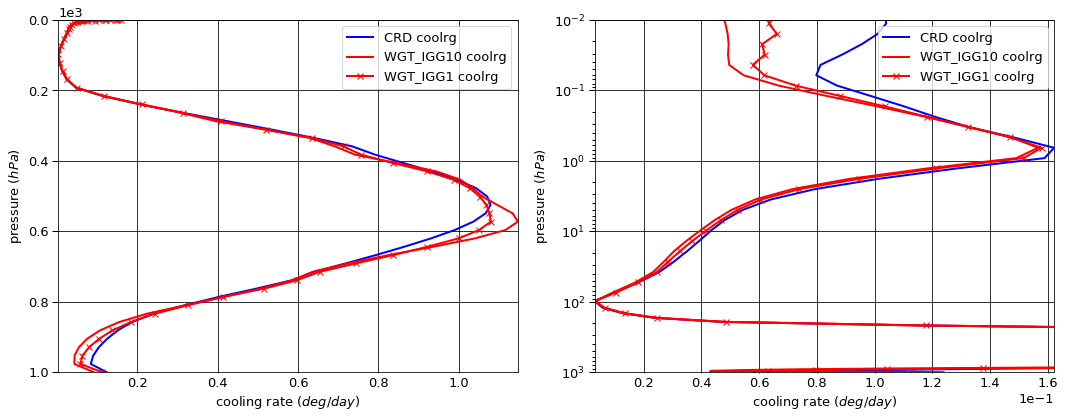

In [19]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [20]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.009115   0.000000  -0.009115
   1013.0   76     -0.014685   0.014677  -0.000008
2  0.0      1      -0.021222   0.000000  -0.021222
   1013.0   76     -0.032359   0.032342  -0.000017
3  0.0      1      -0.023714   0.000000  -0.023714
   1013.0   76     -0.042316   0.042293  -0.000023
4  0.0      1      -0.104711   0.000000  -0.104711
   1013.0   76     -0.227162   0.227041  -0.000121
5  0.0      1      -0.190562   0.000000  -0.190562
   1013.0   76     -0.447223   0.446993  -0.000230
6  0.0      1      -1.311903   0.000000  -1.311903
   1013.0   76     -2.718359   2.716904  -0.001455
7  0.0      1      -3.943767   0.000000  -3.943767
   1013.0   76     -6.999746   6.996002  -0.003743
8  0.0      1     -10.035676   0.000000 -10.035676
   1013.0   76    -15.472665  15.464144  -0.008521
9  0.0      1     -25.057604   0.000000 -25.057604
   1013.0   76    -33.853850  33.767939  -0.085912
10 0.0      1     -15.897618   0.000000 -15.897618
   1013.0   76    -19.306116  18.783965  -0.522151


WGT_IGG10


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.009305   0.000000  -0.009305
   1013.0   76     -0.014685   0.014677  -0.000008
2  0.0      1      -0.021482   0.000000  -0.021482
   1013.0   76     -0.032359   0.032342  -0.000017
3  0.0      1      -0.023932   0.000000  -0.023932
   1013.0   76     -0.042316   0.042293  -0.000023
4  0.0      1      -0.097936   0.000000  -0.097936
   1013.0   76     -0.227162   0.227041  -0.000121
5  0.0      1      -0.183711   0.000000  -0.183711
   1013.0   76     -0.447223   0.446993  -0.000230
6  0.0      1      -1.293773   0.000000  -1.293773
   1013.0   76     -2.718359   2.716904  -0.001455
7  0.0      1      -3.925676   0.000000  -3.925676
   1013.0   76     -6.999746   6.996002  -0.003743
8  0.0      1      -9.997908   0.000000  -9.997908
   1013.0   76    -15.472665  15.464292  -0.008373
9  0.0      1     -25.073784   0.000000 -25.073784
   1013.0   76    -33.853850  33.780487  -0.073364
10 0.0      1     -15.857149   0.000000 -15.857149
   1013.0   76    -19.306116  19.093482  -0.212634


WGT_IGG1


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.009264   0.000000  -0.009264
   1013.0   76     -0.014685   0.014677  -0.000008
2  0.0      1      -0.021245   0.000000  -0.021245
   1013.0   76     -0.032359   0.032342  -0.000017
3  0.0      1      -0.023881   0.000000  -0.023881
   1013.0   76     -0.042316   0.042293  -0.000023
4  0.0      1      -0.098977   0.000000  -0.098977
   1013.0   76     -0.227162   0.227041  -0.000121
5  0.0      1      -0.185782   0.000000  -0.185782
   1013.0   76     -0.447223   0.446993  -0.000230
6  0.0      1      -1.294034   0.000000  -1.294034
   1013.0   76     -2.718359   2.716904  -0.001455
7  0.0      1      -3.927934   0.000000  -3.927934
   1013.0   76     -6.999746   6.996002  -0.003743
8  0.0      1     -10.012076   0.000000 -10.012076
   1013.0   76    -15.472665  15.464292  -0.008373
9  0.0      1     -25.104535   0.000000 -25.104535
   1013.0   76    -33.853850  33.763778  -0.090072
10 0.0      1     -15.862344   0.000000 -15.862344
   1013.0   76    -19.306116  19.061285  -0.244831


WGT_IGG10 - CRD


flug          fldg     fnetg
g  pressure level                                      
1  0.0      1     -1.892290e-04  0.000000e+00 -0.000189
   1013.0   76     1.734723e-18 -1.734723e-18  0.000000
2  0.0      1     -2.605440e-04  0.000000e+00 -0.000261
   1013.0   76     0.000000e+00  0.000000e+00  0.000000
3  0.0      1     -2.176030e-04  0.000000e+00 -0.000218
   1013.0   76    -6.938894e-18  6.938894e-18  0.000000
4  0.0      1      6.774942e-03  0.000000e+00  0.006775
   1013.0   76    -2.775558e-17  0.000000e+00  0.000000
5  0.0      1      6.851110e-03  0.000000e+00  0.006851
   1013.0   76     0.000000e+00  0.000000e+00  0.000000
6  0.0      1      1.813040e-02  0.000000e+00  0.018130
   1013.0   76     0.000000e+00  0.000000e+00  0.000000
7  0.0      1      1.809070e-02  0.000000e+00  0.018091
   1013.0   76     0.000000e+00  8.881784e-16  0.000000
8  0.0      1      3.776830e-02  0.000000e+00  0.037768
   1013.0   76     0.000000e+00  1.480000e-04  0.000148
9  0.0      1     -1.618000e-02  0.000000e+00 -0.016180
   1013.0   76     0.000000e+00  1.254800e-02  0.012548
10 0.0      1      4.046900e-02  0.000000e+00  0.040469
   1013.0   76     0.000000e+00  3.095170e-01  0.309517


WGT_IGG1 - CRD


flug          fldg     fnetg
g  pressure level                                      
1  0.0      1     -1.486436e-04  0.000000e+00 -0.000149
   1013.0   76     1.734723e-18 -1.734723e-18  0.000000
2  0.0      1     -2.290600e-05  0.000000e+00 -0.000023
   1013.0   76     0.000000e+00  0.000000e+00  0.000000
3  0.0      1     -1.664680e-04  0.000000e+00 -0.000166
   1013.0   76    -6.938894e-18  6.938894e-18  0.000000
4  0.0      1      5.734382e-03  0.000000e+00  0.005734
   1013.0   76    -2.775558e-17  0.000000e+00  0.000000
5  0.0      1      4.780740e-03  0.000000e+00  0.004781
   1013.0   76     0.000000e+00  0.000000e+00  0.000000
6  0.0      1      1.786980e-02  0.000000e+00  0.017870
   1013.0   76     0.000000e+00  0.000000e+00  0.000000
7  0.0      1      1.583240e-02  0.000000e+00  0.015832
   1013.0   76     0.000000e+00  8.881784e-16  0.000000
8  0.0      1      2.360000e-02  0.000000e+00  0.023600
   1013.0   76     0.000000e+00  1.480000e-04  0.000148
9  0.0      1     -4.693100e-02  0.000000e+00 -0.046931
   1013.0   76     0.000000e+00 -4.161000e-03 -0.004160
10 0.0      1      3.527400e-02  0.000000e+00  0.035274
   1013.0   76     0.000000e+00  2.773200e-01  0.277320

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1      9.188668e-02
   1001.112500 75     2.777646e-06
2  0.000312    1      2.828661e-03
   1001.112500 75     6.289916e-06
3  0.000312    1      1.576704e-04
   1001.112500 75     8.094211e-06
4  0.000312    1      3.656092e-04
   1001.112500 75     4.362652e-05
5  0.000312    1      5.698168e-08
   1001.112500 75     8.279942e-05
6  0.000312    1      4.759665e-06
   1001.112500 75     5.229761e-04
7  0.000312    1      6.634644e-05
   1001.112500 75     1.345762e-03
8  0.000312    1      1.416722e-04
   1001.112500 75     3.081834e-03
9  0.000312    1      8.787373e-06
   1001.112500 75     3.177108e-02
10 0.000312    1     -3.017408e-07
   1001.112500 75     8.704823e-02


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1      3.272106e-02
   1001.112500 75     2.777646e-06
2  0.000312    1      2.035832e-03
   1001.112500 75     6.289916e-06
3  0.000312    1      1.753785e-04
   1001.112500 75     8.094211e-06
4  0.000312    1      3.662315e-04
   1001.112500 75     4.362652e-05
5  0.000312    1      4.909570e-08
   1001.112500 75     8.279942e-05
6  0.000312    1      3.605219e-06
   1001.112500 75     5.229761e-04
7  0.000312    1      2.642104e-05
   1001.112500 75     1.345762e-03
8  0.000312    1      3.328006e-05
   1001.112500 75     3.009771e-03
9  0.000312    1      9.846684e-08
   1001.112500 75     2.879810e-02
10 0.000312    1     -2.305325e-07
   1001.112500 75     5.784521e-02


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1      4.935886e-02
   1001.112500 75     2.777646e-06
2  0.000312    1      2.520834e-03
   1001.112500 75     6.289916e-06
3  0.000312    1      1.817578e-04
   1001.112500 75     8.094211e-06
4  0.000312    1      4.179655e-04
   1001.112500 75     4.362652e-05
5  0.000312    1      5.769729e-08
   1001.112500 75     8.279942e-05
6  0.000312    1      4.587570e-06
   1001.112500 75     5.229761e-04
7  0.000312    1      3.450700e-05
   1001.112500 75     1.345762e-03
8  0.000312    1      4.677540e-05
   1001.112500 75     3.009771e-03
9  0.000312    1      1.577823e-06
   1001.112500 75     3.476060e-02
10 0.000312    1     -2.151380e-07
   1001.112500 75     7.289374e-02


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -5.916561e-02
   1001.112500 75     0.000000e+00
2  0.000312    1     -7.928289e-04
   1001.112500 75     8.470329e-22
3  0.000312    1      1.770808e-05
   1001.112500 75     0.000000e+00
4  0.000312    1      6.223200e-07
   1001.112500 75     6.776264e-21
5  0.000312    1     -7.885979e-09
   1001.112500 75     0.000000e+00
6  0.000312    1     -1.154446e-06
   1001.112500 75     0.000000e+00
7  0.000312    1     -3.992539e-05
   1001.112500 75     0.000000e+00
8  0.000312    1     -1.083922e-04
   1001.112500 75    -7.206290e-05
9  0.000312    1     -8.688906e-06
   1001.112500 75    -2.972982e-03
10 0.000312    1      7.120834e-08
   1001.112500 75    -2.920302e-02


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -4.252782e-02
   1001.112500 75     0.000000e+00
2  0.000312    1     -3.078278e-04
   1001.112500 75     8.470329e-22
3  0.000312    1      2.408744e-05
   1001.112500 75     0.000000e+00
4  0.000312    1      5.235626e-05
   1001.112500 75     6.776264e-21
5  0.000312    1      7.156110e-10
   1001.112500 75     0.000000e+00
6  0.000312    1     -1.720948e-07
   1001.112500 75     0.000000e+00
7  0.000312    1     -3.183944e-05
   1001.112500 75     0.000000e+00
8  0.000312    1     -9.489685e-05
   1001.112500 75    -7.206290e-05
9  0.000312    1     -7.209550e-06
   1001.112500 75     2.989516e-03
10 0.000312    1      8.660279e-08
   1001.112500 75    -1.415450e-02

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-56.595893,0.0000,-56.595893
1013.0,76,-79.114481,78.4923,-0.622181



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-56.484656,0.000000,-56.484656
1013.0,76,-79.114481,78.814513,-0.299968



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-56.540071,0.000000,-56.540071
1013.0,76,-79.114481,78.765607,-0.348874



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.111237,0.000000,0.111237
1013.0,76,0.000000,0.322213,0.322213



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.055822,0.000000,0.055822
1013.0,76,0.000000,0.273307,0.273308


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.095460
1001.112500,75,0.123913



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.035362
1001.112500,75,0.091665



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.052567
1001.112500,75,0.112676



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.060098
1001.112500,75,-0.032248



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.042893
1001.112500,75,-0.011237


In [21]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000194,0.000191
2,0.000417,0.000415
3,0.000556,0.000548
4,0.002972,0.002934
5,0.006028,0.005876
6,0.035472,0.035078
7,0.091500,0.090356
8,0.200694,0.198606
9,0.430083,0.429875


In [22]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,4.207420e-18
2,4.515983e-19
3,3.585786e-19
4,4.018118e-20
5,8.769537e-20
6,1.186674e-20
7,1.605781e-21
8,2.172908e-22
9,2.940331e-23


In [23]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [24]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,4.207420e-18,NaN,0.000194,0.000191,0.000194,0.000191,1.0
2,4.515983e-19,0.107334,0.000417,0.000415,0.000611,0.000606,1.0
3,3.585786e-19,0.794021,0.000556,0.000548,0.001167,0.001154,10.0
4,4.018118e-20,0.112057,0.002972,0.002934,0.004139,0.004088,10.0
5,8.769537e-20,2.182498,0.006028,0.005876,0.010167,0.009964,500.0
6,1.186674e-20,0.135318,0.035472,0.035078,0.045639,0.045042,500.0
7,1.605781e-21,0.135318,0.091500,0.090356,0.137139,0.135398,500.0
8,2.172908e-22,0.135318,0.200694,0.198606,0.337833,0.334004,500.0
9,2.940331e-23,0.135318,0.430083,0.429875,0.767917,0.763879,500.0


In [25]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [26]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g  pressure                                                        
1     1  0.000312     1.377471e-17  6.898582e-18   1.996745  6.676497e-04
      2  0.000312     5.437316e-19  3.388767e-19   1.604512  2.911789e-05
      3  0.000312     1.350414e-20  1.234549e-20   1.093852  8.862952e-07
      4  0.000312     4.026370e-21  2.411130e-21   1.669910  2.115399e-07
      5  0.000312     1.818127e-25  1.818125e-25   1.000001  1.258024e-11
      6  0.000312     3.047240e-24  2.823208e-24   1.079354  2.015480e-10
      7  0.000312     2.209130e-23  4.653335e-24   4.747411  8.046171e-10
      8  0.000312     2.860787e-23  1.082847e-24  26.419136  8.367463e-10
      9  0.000312     2.064287e-24  1.065976e-25  19.365228  6.155955e-11
      10 0.000312     7.355019e-26  1.458100e-26   5.044249  3.865106e-12
2     1  0.000750     1.380004e-17  6.912329e-18   1.996438  2.694326e-04
      2  0.000750     5.481073e-19  3.418595e-19   1.603312  1.182696e-05
      3  0.000750     1.368823e-20  1.250816e-20   1.094344  3.617604e-07
      4  0.000750     4.069580e-21  2.432772e-21   1.672816  8.604908e-08
      5  0.000750     4.372604e-25  4.372595e-25   1.000002  1.218652e-11
      6  0.000750     3.126715e-24  2.898775e-24   1.078633  8.333050e-11
      7  0.000750     2.221593e-23  4.686654e-24   4.740253  3.260357e-10
      8  0.000750     2.881015e-23  1.087474e-24  26.492716  3.393626e-10
      9  0.000750     2.076280e-24  1.071544e-25  19.376523  2.493838e-11
      10 0.000750     7.425615e-26  1.467675e-26   5.059441  1.571386e-12
3     1  0.001052     1.385238e-17  6.940349e-18   1.995920  3.793239e-04
      2  0.001052     5.570366e-19  3.478857e-19   1.601206  1.686688e-05
      3  0.001052     1.402992e-20  1.280486e-20   1.095672  5.196273e-07
      4  0.001052     4.153721e-21  2.472548e-21   1.679935  1.229222e-07
      5  0.001052     6.190036e-25  6.190018e-25   1.000003  2.419356e-11
      6  0.001052     3.219974e-24  2.984326e-24   1.078962  1.203258e-10
      7  0.001052     2.246292e-23  4.745840e-24   4.733182  4.624772e-10
      8  0.001052     2.922470e-23  1.095864e-24  26.668196  4.825951e-10
      9  0.001052     2.100876e-24  1.081935e-25  19.417766  3.538212e-11
      10 0.001052     7.569621e-26  1.485663e-26   5.095112  2.245198e-12
4     1  0.001476     1.390511e-17  6.968788e-18   1.995341  5.342425e-04
      2  0.001476     5.662588e-19  3.541084e-19   1.599111  2.406939e-05
      3  0.001476     1.439150e-20  1.311924e-20   1.096977  7.472541e-07
      4  0.001476     4.241890e-21  2.514326e-21   1.687088  1.757549e-07
      5  0.001476     8.765695e-25  8.765659e-25   1.000004  4.806367e-11
      6  0.001476     3.330291e-24  3.086695e-24   1.078918  1.745914e-10
      7  0.001476     2.271854e-23  4.808030e-24   4.725124  6.564578e-10
      8  0.001476     2.965177e-23  1.104689e-24  26.841737  6.866858e-10
      9  0.001476     2.126309e-24  1.092747e-25  19.458379  5.023069e-11
      10 0.001476     7.719411e-26  1.504218e-26   5.131844  3.210315e-12
5     1  0.002070     1.395739e-17  6.997249e-18   1.994697  7.522432e-04
      2  0.002070     5.756599e-19  3.604555e-19   1.597034  3.434149e-05
      3  0.002070     1.477219e-20  1.345113e-20   1.098212  1.075114e-06
      4  0.002070     4.333457e-21  2.558012e-21   1.694072  2.513441e-07
      5  0.002070     1.241483e-24  1.241476e-24   1.000006  9.547740e-11
      6  0.002070     3.463218e-24  3.211448e-24   1.078398  2.547254e-10
      7  0.002070     2.298029e-23  4.873269e-24   4.715579  9.318016e-10
      8  0.002070     3.008583e-23  1.113942e-24  27.008431  9.769163e-10
      9  0.002070     2.152265e-24  1.103931e-25  19.496365  7.130297e-11
      10 0.002070     7.873280e-26  1.523236e-26   5.168785  4.589968e-12
6     1  0.002904     1.400908e-17  7.025704e-18   1.993975  1.059272e-03
      2  0.002904     5.852467e-19  3.669388e-19   1.594944  4.900544e-05
      3  0.002904     1.517692e

# Histogram of wavenumbers in g-group 1

In [27]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [28]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
